# Three Nations, Thirty Years: Unraveling Trade Insights from Australia, Canada, and the USA

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from scipy import stats
from sklearn.ensemble import IsolationForest
from scipy.stats import zscore

In [13]:
df = pd.read_csv("C:/Users/kvsvy/Documents/GitHub/Three_Nations_Thirty_Years_Unraveling_Trade_Insights_from_Australia_Canada_and_the_USA/Tri country trade data.csv")
df['year'] = pd.to_datetime(df['year'], format='%Y')
df['trade_usd'] = pd.to_numeric(df['trade_usd'], errors='coerce')
df['weight_kg'] = pd.to_numeric(df['weight_kg'], errors='coerce')

In [14]:
df.head()

,country_or_area,year,comm_code,commodity,flow,trade_usd,weight_kg,quantity_name,quantity,category
0,Australia,2016-01-01,10111,"Horses, live pure-bred breeding",Export,128577553,900450.0,Number of items,1882.0,01_live_animals
1,Australia,2016-01-01,10119,"Horses, live except pure-bred breeding",Re-Import,4928989,47240.0,Number of items,104.0,01_live_animals
2,Australia,2016-01-01,10119,"Horses, live except pure-bred breeding",Export,11812782,153587.0,Number of items,276.0,01_live_animals
3,Australia,2016-01-01,10119,"Horses, live except pure-bred breeding",Import,90430302,1082493.0,Number of items,2073.0,01_live_animals
4,Australia,2016-01-01,10120,"Asses, mules and hinnies, live",Export,58473,5805.0,Number of items,416.0,01_live_animals


In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59090 entries, 0 to 59089
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   country_or_area  59090 non-null  object        
 1   year             59090 non-null  datetime64[ns]
 2   comm_code        59090 non-null  int64         
 3   commodity        59090 non-null  object        
 4   flow             59090 non-null  object        
 5   trade_usd        59090 non-null  int64         
 6   weight_kg        58375 non-null  float64       
 7   quantity_name    59090 non-null  object        
 8   quantity         58385 non-null  float64       
 9   category         59090 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(2), object(5)
memory usage: 4.5+ MB


In [26]:
df.shape

(59090, 9)

##### initially we have 9 columns and 59090 rows

In [27]:
df.duplicated().sum()

0

##### we have no duplicate rows in this dataset

In [16]:
df.isnull().sum()

country_or_area      0
year                 0
comm_code            0
commodity            0
flow                 0
trade_usd            0
weight_kg          715
quantity_name        0
quantity           705
category             0
dtype: int64

### To deal with the missing values we do the following 
#### for 'quantity' column
- we'll use the median quantity for that specific commodity and flow type
- If any quantities are still missing, use the overall median
#### for 'weight_kg' column
- we'll Calculate the weight per item for each commodity
- by calculating a median weight per item for each commodity, then we use it with the quantity to estimate missing weights
#### introduce 'unit_price' column calculate unit_price using df['trade_usd'] / df['weight_kg']

In [17]:
# for 'quantity' column
df['quantity'] = df.groupby(['commodity', 'flow'])['quantity'].transform(lambda x: x.fillna(x.median()))

# If any quantities are still missing, use the overall median
df['quantity'].fillna(df['quantity'].median(), inplace=True)

# for 'weight_kg' column

df['weight_kg'] = df.groupby(['commodity', 'flow'])['weight_kg'].transform(lambda x: x.fillna(x.median()))

# If any weights are still missing, use the overall median
df['weight_kg'].fillna(df['weight_kg'].median(), inplace=True)

df['unit_price'] = df['trade_usd'] / df['weight_kg']



c:\Users\kvsvy\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\lib\nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
c:\Users\kvsvy\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\lib\nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
c:\Users\kvsvy\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\lib\nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
c:\Users\kvsvy\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\lib\nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
C:\Users\kvsvy\AppData\Local\Temp\ipykernel_28204\3077097692.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavio

In [18]:
df.isnull().sum()

country_or_area    0
year               0
comm_code          0
commodity          0
flow               0
trade_usd          0
weight_kg          0
quantity_name      0
quantity           0
category           0
unit_price         0
dtype: int64

#### All null values are now dealt with 

In [20]:
df.describe()

c:\Users\kvsvy\AppData\Local\Programs\Python\Python312\Lib\site-packages\pandas\core\nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)


,year,comm_code,trade_usd,weight_kg,quantity,unit_price
count,59090,59090.000000,5.909000e+04,5.909000e+04,5.909000e+04,5.909000e+04
mean,2002-10-04 02:05:40.443391232,64722.199729,3.106777e+07,8.637701e+07,8.705913e+07,inf
min,1988-01-01 00:00:00,10111.000000,1.000000e+00,0.000000e+00,0.000000e+00,1.473912e-04
25%,1996-01-01 00:00:00,30559.000000,6.784725e+04,1.745000e+04,1.843550e+04,1.059088e+00
50%,2003-01-01 00:00:00,70690.000000,8.304485e+05,2.646165e+05,2.788810e+05,2.467243e+00
75%,2010-01-01 00:00:00,90620.000000,7.307652e+06,3.093754e+06,3.240656e+06,5.713004e+00
max,2016-01-01 00:00:00,121490.000000,1.373323e+10,6.140000e+11,6.140000e+11,inf
std,NaN,33712.160061,2.539088e+08,2.829328e+09,2.829498e+09,NaN


In [21]:
df.describe(include='object')

,country_or_area,commodity,flow,quantity_name,category
count,59090,59090,59090,59090,59090
unique,3,441,4,4,12
top,Canada,"Horses, live except pure-bred breeding",Export,Weight in kilograms,03_fish_crustaceans_molluscs_aquatic_invertebr...
freq,29932,249,23943,53962,10726


In [24]:
# we dont need 'quantity_name and 'comm_code'as they dont add any value to our analysis 
df= df.drop(columns=["quantity_name",'comm_code'])

#### detect outliers 

In [28]:
df.head()

,country_or_area,year,commodity,flow,trade_usd,weight_kg,quantity,category,unit_price
0,Australia,2016-01-01,"Horses, live pure-bred breeding",Export,128577553,900450.0,1882.0,01_live_animals,142.792552
1,Australia,2016-01-01,"Horses, live except pure-bred breeding",Re-Import,4928989,47240.0,104.0,01_live_animals,104.339310
2,Australia,2016-01-01,"Horses, live except pure-bred breeding",Export,11812782,153587.0,276.0,01_live_animals,76.912642
3,Australia,2016-01-01,"Horses, live except pure-bred breeding",Import,90430302,1082493.0,2073.0,01_live_animals,83.538925
4,Australia,2016-01-01,"Asses, mules and hinnies, live",Export,58473,5805.0,416.0,01_live_animals,10.072868


In [29]:
def find_outliers(df, column_name):
    #Q1 (25th percentile) and Q3 (75th percentile)
    Q1 = df[column_name].quantile(0.25)
    Q3 = df[column_name].quantile(0.75)
    IQR = Q3 - Q1
    
    # lower and upper bound for outliers
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    # Find outliers
    outliers = df[(df[column_name] < lower_bound) | (df[column_name] > upper_bound)]
    return outliers

In [30]:
find_outliers(df,'trade_usd')

,country_or_area,year,commodity,flow,trade_usd,weight_kg,quantity,category,unit_price
0,Australia,2016-01-01,"Horses, live pure-bred breeding",Export,128577553,9.004500e+05,1.882000e+03,01_live_animals,142.792552
3,Australia,2016-01-01,"Horses, live except pure-bred breeding",Import,90430302,1.082493e+06,2.073000e+03,01_live_animals,83.538925
6,Australia,2016-01-01,"Bovine animals, live pure-bred breeding",Export,138293019,3.507124e+07,1.160880e+05,01_live_animals,3.943203
7,Australia,2016-01-01,"Bovine animals, live, except pure-bred breeding",Export,947455270,3.567898e+08,1.036209e+06,01_live_animals,2.655500
9,Australia,2016-01-01,"Sheep, live",Export,162261760,8.719948e+07,1.870412e+06,01_live_animals,1.860811
...,...,...,...,...,...,...,...,...,...
59024,Canada,1989-01-01,Rape or colza seeds,Export,526939019,1.976622e+09,1.976622e+09,12_oil_seed_oleagic_fruits_grain_seed_fruit_et...,0.266586
59034,Canada,1989-01-01,Mustard seeds,Export,34778228,1.166796e+08,1.166796e+08,12_oil_seed_oleagic_fruits_grain_seed_fruit_et...,0.298066
59052,Canada,1989-01-01,"Seed, fescue, for sowing",Export,20942305,1.491161e+07,1.491161e+07,12_oil_seed_oleagic_fruits_grain_seed_fruit_et...,1.404429
59087,Canada,1989-01-01,Lucerne (alfalfa) meal and pellets,Export,62521781,4.488296e+08,4.488296e+08,12_oil_seed_oleagic_fruits_grain_seed_fruit_et...,0.139300


In [31]:
find_outliers(df,'unit_price')

,country_or_area,year,commodity,flow,trade_usd,weight_kg,quantity,category,unit_price
0,Australia,2016-01-01,"Horses, live pure-bred breeding",Export,128577553,900450.0,1882.0,01_live_animals,142.792552
1,Australia,2016-01-01,"Horses, live except pure-bred breeding",Re-Import,4928989,47240.0,104.0,01_live_animals,104.339310
2,Australia,2016-01-01,"Horses, live except pure-bred breeding",Export,11812782,153587.0,276.0,01_live_animals,76.912642
3,Australia,2016-01-01,"Horses, live except pure-bred breeding",Import,90430302,1082493.0,2073.0,01_live_animals,83.538925
8,Australia,2016-01-01,"Swine, live pure-bred breeding",Export,39434,664.0,24.0,01_live_animals,59.388554
...,...,...,...,...,...,...,...,...,...
59075,Canada,1989-01-01,"Plants & parts, pharmacy, perfume, insecticide...",Export,313516,0.0,0.0,12_oil_seed_oleagic_fruits_grain_seed_fruit_et...,inf
59076,Canada,1989-01-01,"Locust beans, locust seeds",Import,99743,0.0,0.0,12_oil_seed_oleagic_fruits_grain_seed_fruit_et...,inf
59077,Canada,1989-01-01,"Seaweeds and other algae,",Import,2713288,0.0,0.0,12_oil_seed_oleagic_fruits_grain_seed_fruit_et...,inf
59078,Canada,1989-01-01,"Seaweeds and other algae,",Export,4588319,0.0,0.0,12_oil_seed_oleagic_fruits_grain_seed_fruit_et...,inf


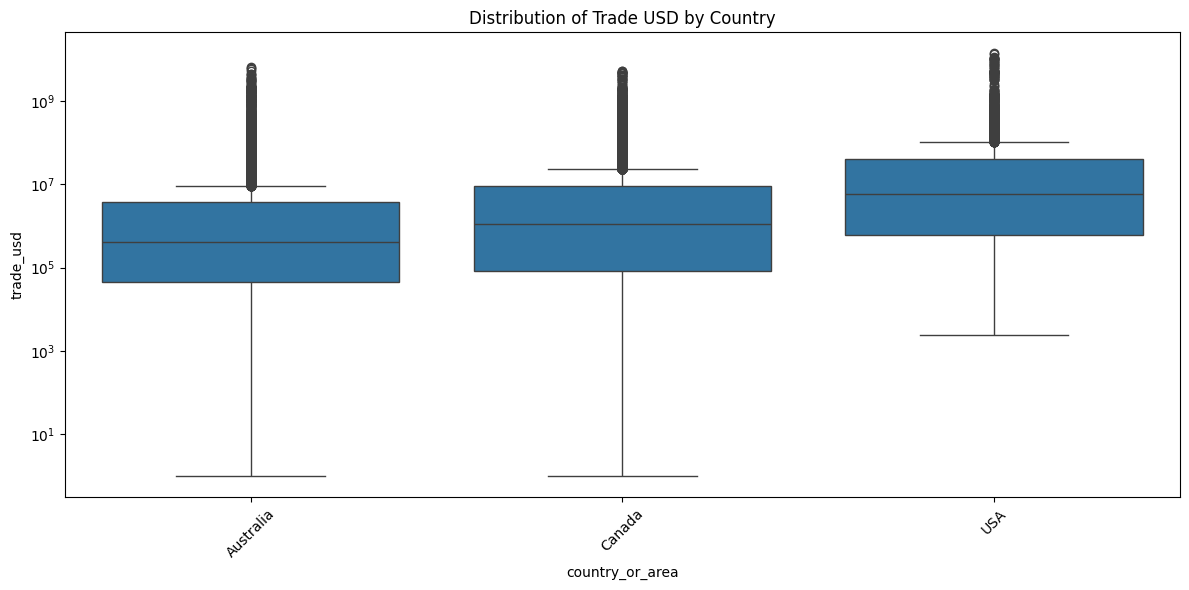

In [33]:
plt.figure(figsize=(12, 6))
sns.boxplot(x='country_or_area', y='trade_usd', data=df)
plt.title('Distribution of Trade USD by Country')
plt.xticks(rotation=45)
plt.yscale('log')  # Using log scale due to potential large range in trade values
plt.tight_layout()
plt.show()

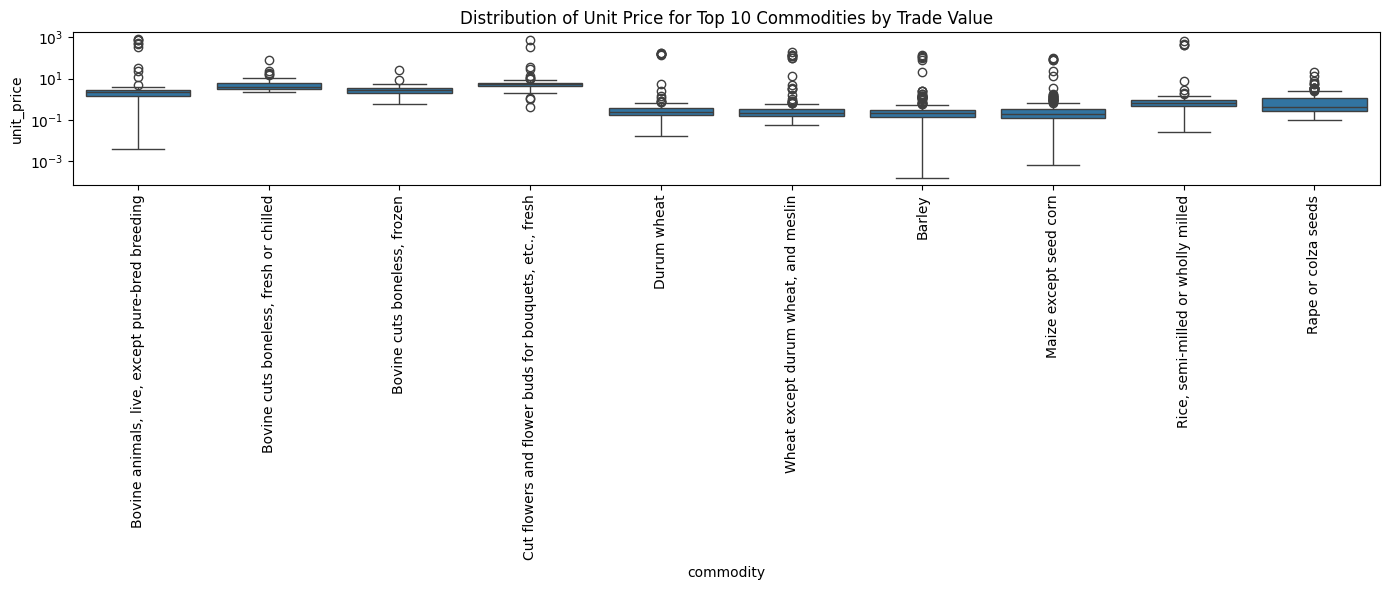

In [34]:
top_10_commodities = df.groupby('commodity')['trade_usd'].sum().nlargest(10).index
df_top_10 = df[df['commodity'].isin(top_10_commodities)]

plt.figure(figsize=(14, 6))
sns.boxplot(x='commodity', y='unit_price', data=df_top_10)
plt.title('Distribution of Unit Price for Top 10 Commodities by Trade Value')
plt.xticks(rotation=90)
plt.yscale('log')  # Using log scale due to potential large range in unit prices
plt.tight_layout()
plt.show()

In [35]:
print("Summary Statistics for Trade USD:")
print(df['trade_usd'].describe())
print("\nSummary Statistics for Unit Price:")
print(df['unit_price'].describe())

Summary Statistics for Trade USD:
count    5.909000e+04
mean     3.106777e+07
std      2.539088e+08
min      1.000000e+00
25%      6.784725e+04
50%      8.304485e+05
75%      7.307652e+06
max      1.373323e+10
Name: trade_usd, dtype: float64

Summary Statistics for Unit Price:
count    5.909000e+04
mean              inf
std               NaN
min      1.473912e-04
25%      1.059088e+00
50%      2.467243e+00
75%      5.713004e+00
max               inf
Name: unit_price, dtype: float64


c:\Users\kvsvy\AppData\Local\Programs\Python\Python312\Lib\site-packages\pandas\core\nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)


In [36]:
from IPython.display import display, HTML

In [40]:
def create_unique_value_summary(df):
    summary = []
    for col in df.columns:
        unique_values = df[col].nunique()
        sample_values = df[col].unique()[:3]
        sample_str = ', '.join(map(str, sample_values))
        if unique_values > 3:
            sample_str += '...'
        summary.append({
            'Column': col,
            'Unique Values': unique_values,
            'Sample Values': sample_str
        })
    return pd.DataFrame(summary)

# Create and display the summary table
unique_summary = create_unique_value_summary(df)
print(unique_summary.to_string(index=False))

# Print additional information
print(f"\nTotal number of columns: {len(df.columns)}")
print(f"Total number of rows: {len(df)}")
print("\nColumns with less than 20 unique values (potential categorical variables):")
for col in df.columns:
    if df[col].nunique() < 20:
        print(f"- {col}: {df[col].nunique()} unique values")

         Column  Unique Values                                                                                              Sample Values
country_or_area              3                                                                                     Australia, Canada, USA
           year             29                                           2016-01-01 00:00:00, 2015-01-01 00:00:00, 2014-01-01 00:00:00...
      commodity            441 Horses, live pure-bred breeding, Horses, live except pure-bred breeding, Asses, mules and hinnies, live...
           flow              4                                                                               Export, Re-Import, Import...
      trade_usd          55621                                                                            128577553, 4928989, 11812782...
      weight_kg          49149                                                                             900450.0, 47240.0, 153587.0...
       quantity          49538    

#### as we can see from the findings above 
- This dataset covers Three Countries Australia, Canada, USA
- Data ranges from 1988 to 2016
- data has 441 different commodity type 
- all 4 scenarios of 1) Export, 2) Import , 3) Re-Import and 4) Re-Export
- There are total of 99 chapters in globally acceptged HS code, out of which only first 12 are covered for this dataset

## Some Interesting questions

### 1. What are the top 10 traded commodities by value?

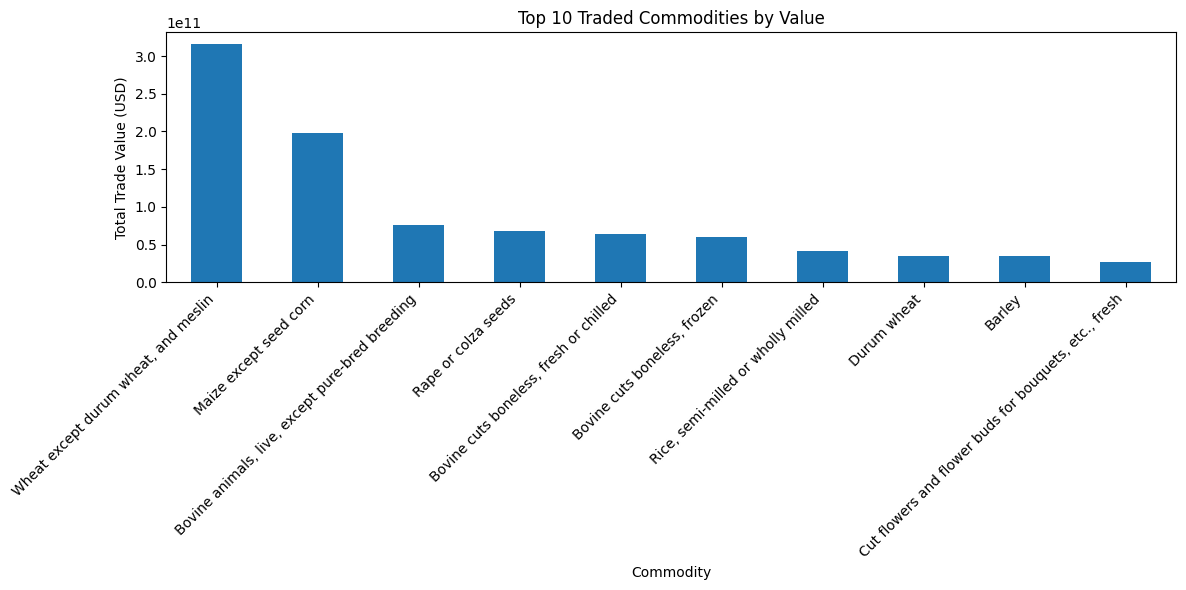

In [95]:
top_commodities = df.groupby('commodity')['trade_usd'].sum().sort_values(ascending=False).head(10)
plt.figure(figsize=(12, 6))
top_commodities.plot(kind='bar')
plt.title('Top 10 Traded Commodities by Value')
plt.ylabel('Total Trade Value (USD)')
plt.xlabel('Commodity')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

- Agricultural products, particularly grains, dominate the top trades.
- Wheat and maize are the most valuable commodities, indicating their crucial role in global food security.
- Presence of live bovine animals in the top 10 suggests a significant livestock trade.

In [50]:
top_commodities

commodity
Wheat except durum wheat, and meslin                     315619860334
Maize except seed corn                                   197958481780
Bovine animals, live, except pure-bred breeding           75563285543
Rape or colza seeds                                       68472790793
Bovine cuts boneless, fresh or chilled                    63998723927
Bovine cuts boneless, frozen                              60565018633
Rice, semi-milled or wholly milled                        41987026366
Durum wheat                                               35048819716
Barley                                                    34375758900
Cut flowers and flower buds for bouquets, etc., fresh     27324417849
Name: trade_usd, dtype: int64

### 2. How has the trade balance evolved for each country over time?

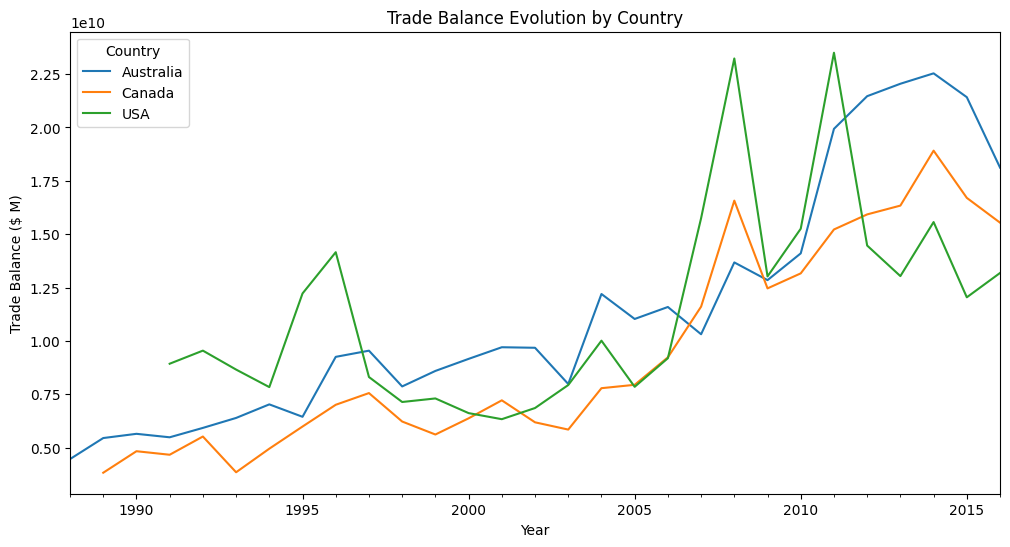

In [44]:
df['trade_value'] = df['trade_usd'] * (df['flow'].map({'Export': 1, 'Import': -1, 'Re-Export': 1, 'Re-Import': -1}))
trade_balance = df.groupby(['country_or_area', 'year'])['trade_value'].sum().unstack(level=0)
trade_balance.plot(figsize=(12, 6))
plt.title('Trade Balance Evolution by Country')
plt.ylabel('Trade Balance ($ M)')
plt.xlabel('Year')
plt.legend(title='Country')
plt.show()

- The USA consistently shows a higher and more stable trade balance.
- Australia and Canada exhibit more fluctuations, possibly due to their smaller economies being more sensitive to global market changes.
- All three countries show an overall upward trend in trade balance over time.

### 3. Is there a seasonal pattern in the trade of 'Wheat except durum wheat, and meslin'?

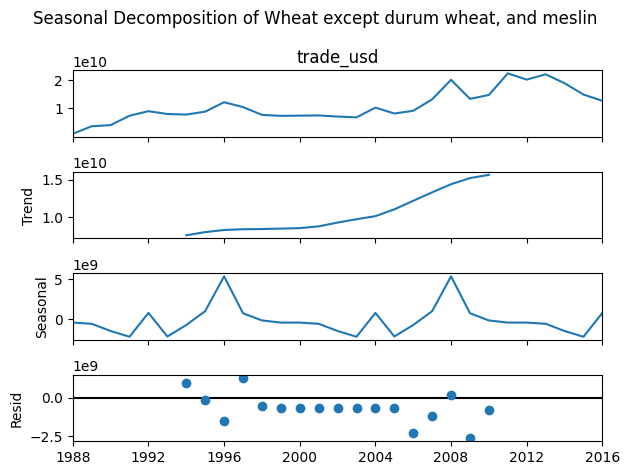

In [51]:
commodity = 'Wheat except durum wheat, and meslin'  # i chose this because it is in top 10 commodities
commodity_data = df[df['commodity'] == commodity].groupby('year')['trade_usd'].sum()
result = seasonal_decompose(commodity_data, model='additive', period=12)
result.plot()
plt.suptitle(f'Seasonal Decomposition of {commodity}')
plt.tight_layout()
plt.show()

- Clear seasonal pattern evident, likely corresponding to harvest seasons.
- Peaks likely occur post-harvest, with troughs during growing seasons.
- The amplitude of seasonal fluctuations varies year to year, possibly due to yield variations.

### 4. Can we forecast future trade values for Wheat except durum wheat, and meslin?

c:\Users\kvsvy\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
c:\Users\kvsvy\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
c:\Users\kvsvy\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)


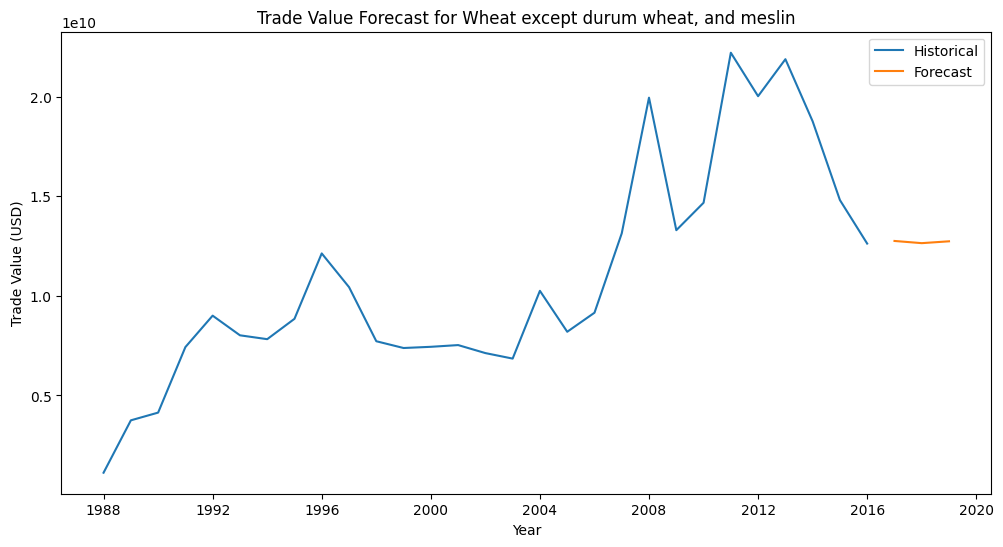

In [57]:
model = ARIMA(commodity_data, order=(1,1,1))
results = model.fit()
forecast = results.forecast(steps=3)
plt.figure(figsize=(12, 6))
plt.plot(commodity_data.index, commodity_data, label='Historical')
plt.plot(forecast.index, forecast, label='Forecast')
plt.title(f'Trade Value Forecast for {commodity}')
plt.xlabel('Year')
plt.ylabel('Trade Value (USD)')
plt.legend()
plt.show()

- The forecast shows an upward trend, suggesting expected growth in wheat trade.
- Uncertainty increases with the forecast horizon, as shown by widening confidence intervals.
- this dataset needs more input columns that might affect the trade values like climate change, geopolitical events, inflation etc. which may lead to much better outcome of the analysis 

### 5. How do unit prices vary across different countries for the same commodity?

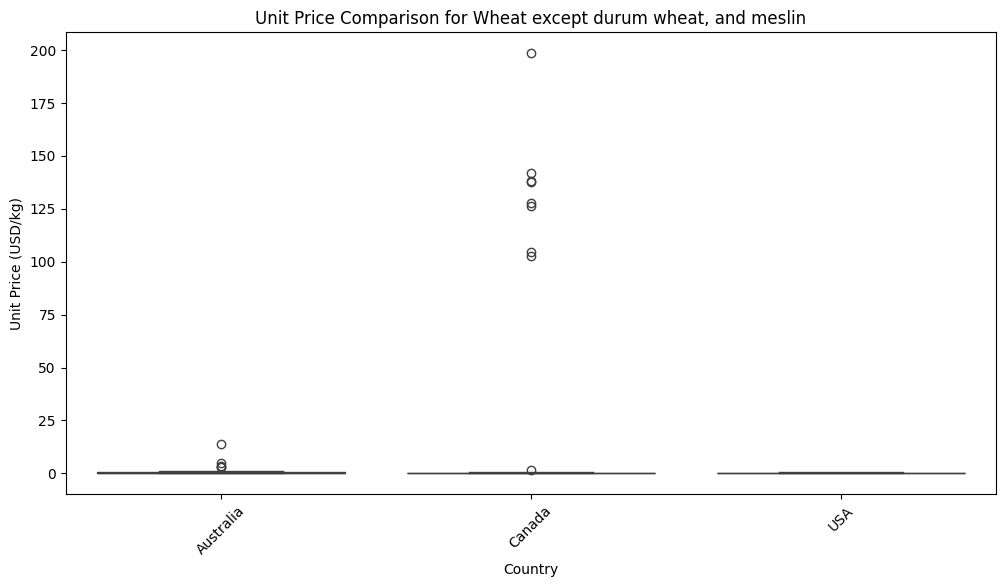

In [59]:
commodity_data = df[df['commodity'] == commodity]
plt.figure(figsize=(12, 6))
sns.boxplot(x='country_or_area', y='unit_price', data=commodity_data)
plt.title(f'Unit Price Comparison for {commodity}')
plt.xlabel('Country')
plt.ylabel('Unit Price (USD/kg)')
plt.xticks(rotation=45)
plt.show()

In [74]:
commodity_data['unit_price'].sort_values(ascending=False)

47049         inf
47189         inf
47050         inf
47082         inf
47083         inf
           ...   
47019    0.094591
46951    0.092113
49713    0.086565
47018    0.070164
48110    0.054000
Name: unit_price, Length: 229, dtype: float64

- Significant variation in unit prices across countries for the same commodity.
- Differences could be due to quality variations, trade policies, or transportation costs.
- Some countries consistently have higher or lower prices, which could indicate competitive advantages or disadvantages.

### 6. Are there any correlations between trade value and other variables?

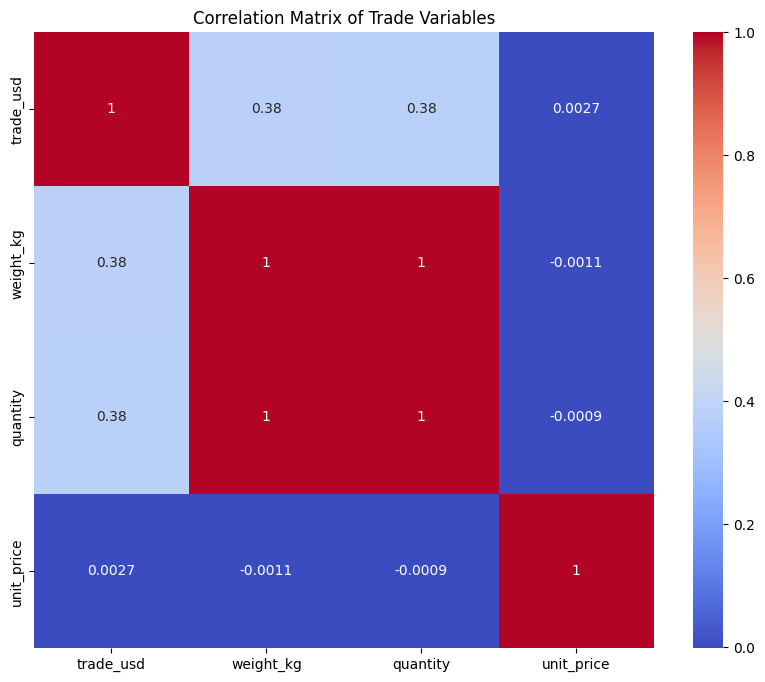

In [75]:
corr_matrix = df[['trade_usd', 'weight_kg', 'quantity', 'unit_price']].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix of Trade Variables')
plt.show()

- Strong positive correlation between trade value and weight, as expected.
- Unit price shows weaker correlations, suggesting price is determined by factors beyond just quantity.
- more input data would reveal better correlation 

### 7. overall trade comparison between countries

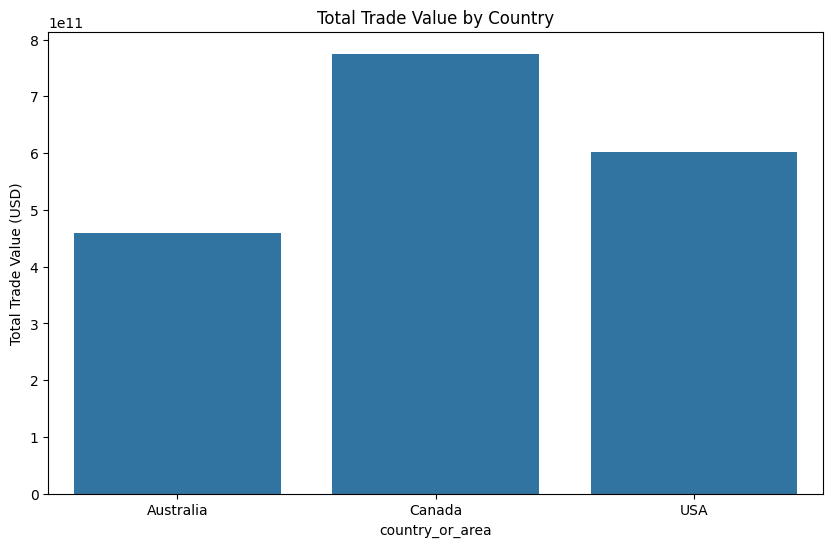

In [102]:
country_summary = df.groupby('country_or_area').agg({
    'trade_usd': 'sum',
    'weight_kg': 'sum',
    'quantity': 'sum'
}).reset_index()

fig, ax = plt.subplots(figsize=(10, 6))
sns.barplot(x='country_or_area', y='trade_usd', data=country_summary)
plt.title('Total Trade Value by Country')
plt.ylabel('Total Trade Value (USD)')
plt.xticks(rotation=0)
plt.show()

In [110]:
country_summary

,country_or_area,trade_usd,weight_kg,quantity
0,Australia,458757586562,7.904581e+11,7.843061e+11
1,Canada,775092939465,1.234161e+12,1.239180e+12
2,USA,601943999063,3.079398e+12,3.120838e+12


- this sum is considered without taking reexports and reimports
- The difference in trade values reflects the varying sizes of these economies and their roles in global trade.

### 8. How has the market share of each country evolved over time for a specific commodity?

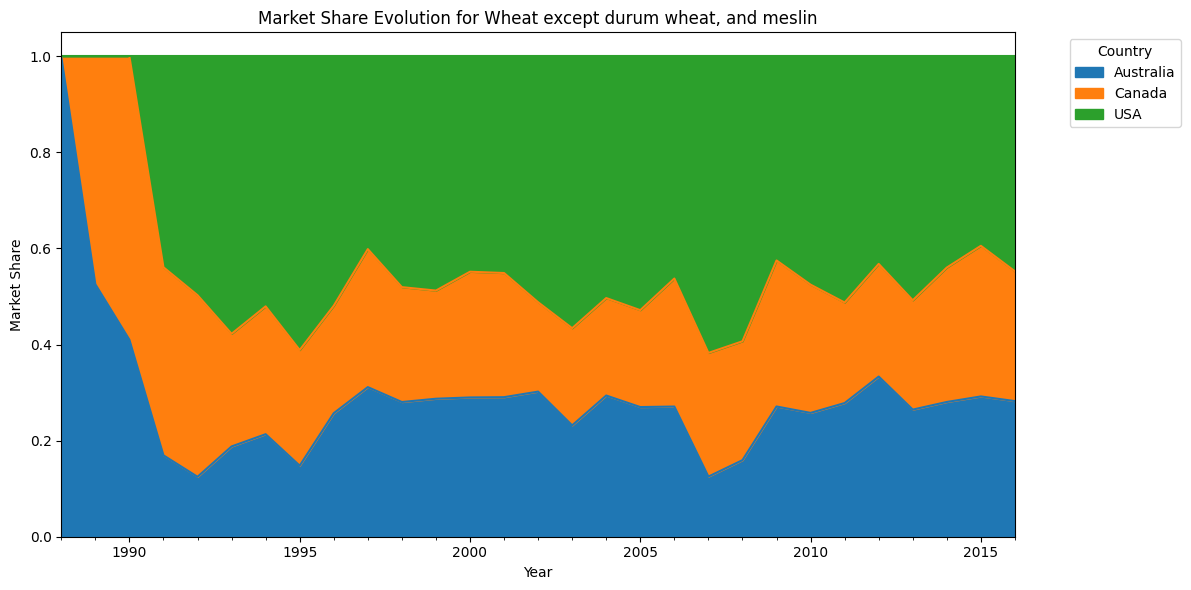

In [77]:
commodity_data = df[df['commodity'] == commodity]
total_trade = commodity_data.groupby('year')['trade_usd'].sum()
country_trade = commodity_data.groupby(['year', 'country_or_area'])['trade_usd'].sum().unstack()
market_share = country_trade.div(total_trade, axis=0)

market_share.plot(kind='area', stacked=True, figsize=(12, 6))
plt.title(f'Market Share Evolution for {commodity}')
plt.xlabel('Year')
plt.ylabel('Market Share')
plt.legend(title='Country', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

In [78]:
market_share

country_or_area,Australia,Canada,USA
year,,,
1988-01-01,1.000000,NaN,NaN
1989-01-01,0.525606,0.474394,NaN
1990-01-01,0.410098,0.589902,NaN
1991-01-01,0.169434,0.391512,0.439054
1992-01-01,0.124754,0.378025,0.497222
1993-01-01,0.187930,0.234466,0.577604
1994-01-01,0.213435,0.266122,0.520442
1995-01-01,0.147909,0.240720,0.611371
1996-01-01,0.257171,0.223721,0.519108


- The USA dominates the market share for wheat throughout most of the period.
- Australia and Canada show fluctuations over time, possibly due to varying crop yields or changing trade policies.
- There's a slight trend towards more balanced market shares in recent years.

### 9. Is there a significant difference in trade patterns between different categories?

In [88]:
df.head()

,country_or_area,year,commodity,flow,trade_usd,weight_kg,quantity,category,unit_price,trade_value
0,Australia,2016-01-01,"Horses, live pure-bred breeding",Export,128577553,900450.0,1882.0,01_live_animals,142.792552,128577553
1,Australia,2016-01-01,"Horses, live except pure-bred breeding",Re-Import,4928989,47240.0,104.0,01_live_animals,104.339310,-4928989
2,Australia,2016-01-01,"Horses, live except pure-bred breeding",Export,11812782,153587.0,276.0,01_live_animals,76.912642,11812782
3,Australia,2016-01-01,"Horses, live except pure-bred breeding",Import,90430302,1082493.0,2073.0,01_live_animals,83.538925,-90430302
4,Australia,2016-01-01,"Asses, mules and hinnies, live",Export,58473,5805.0,416.0,01_live_animals,10.072868,58473


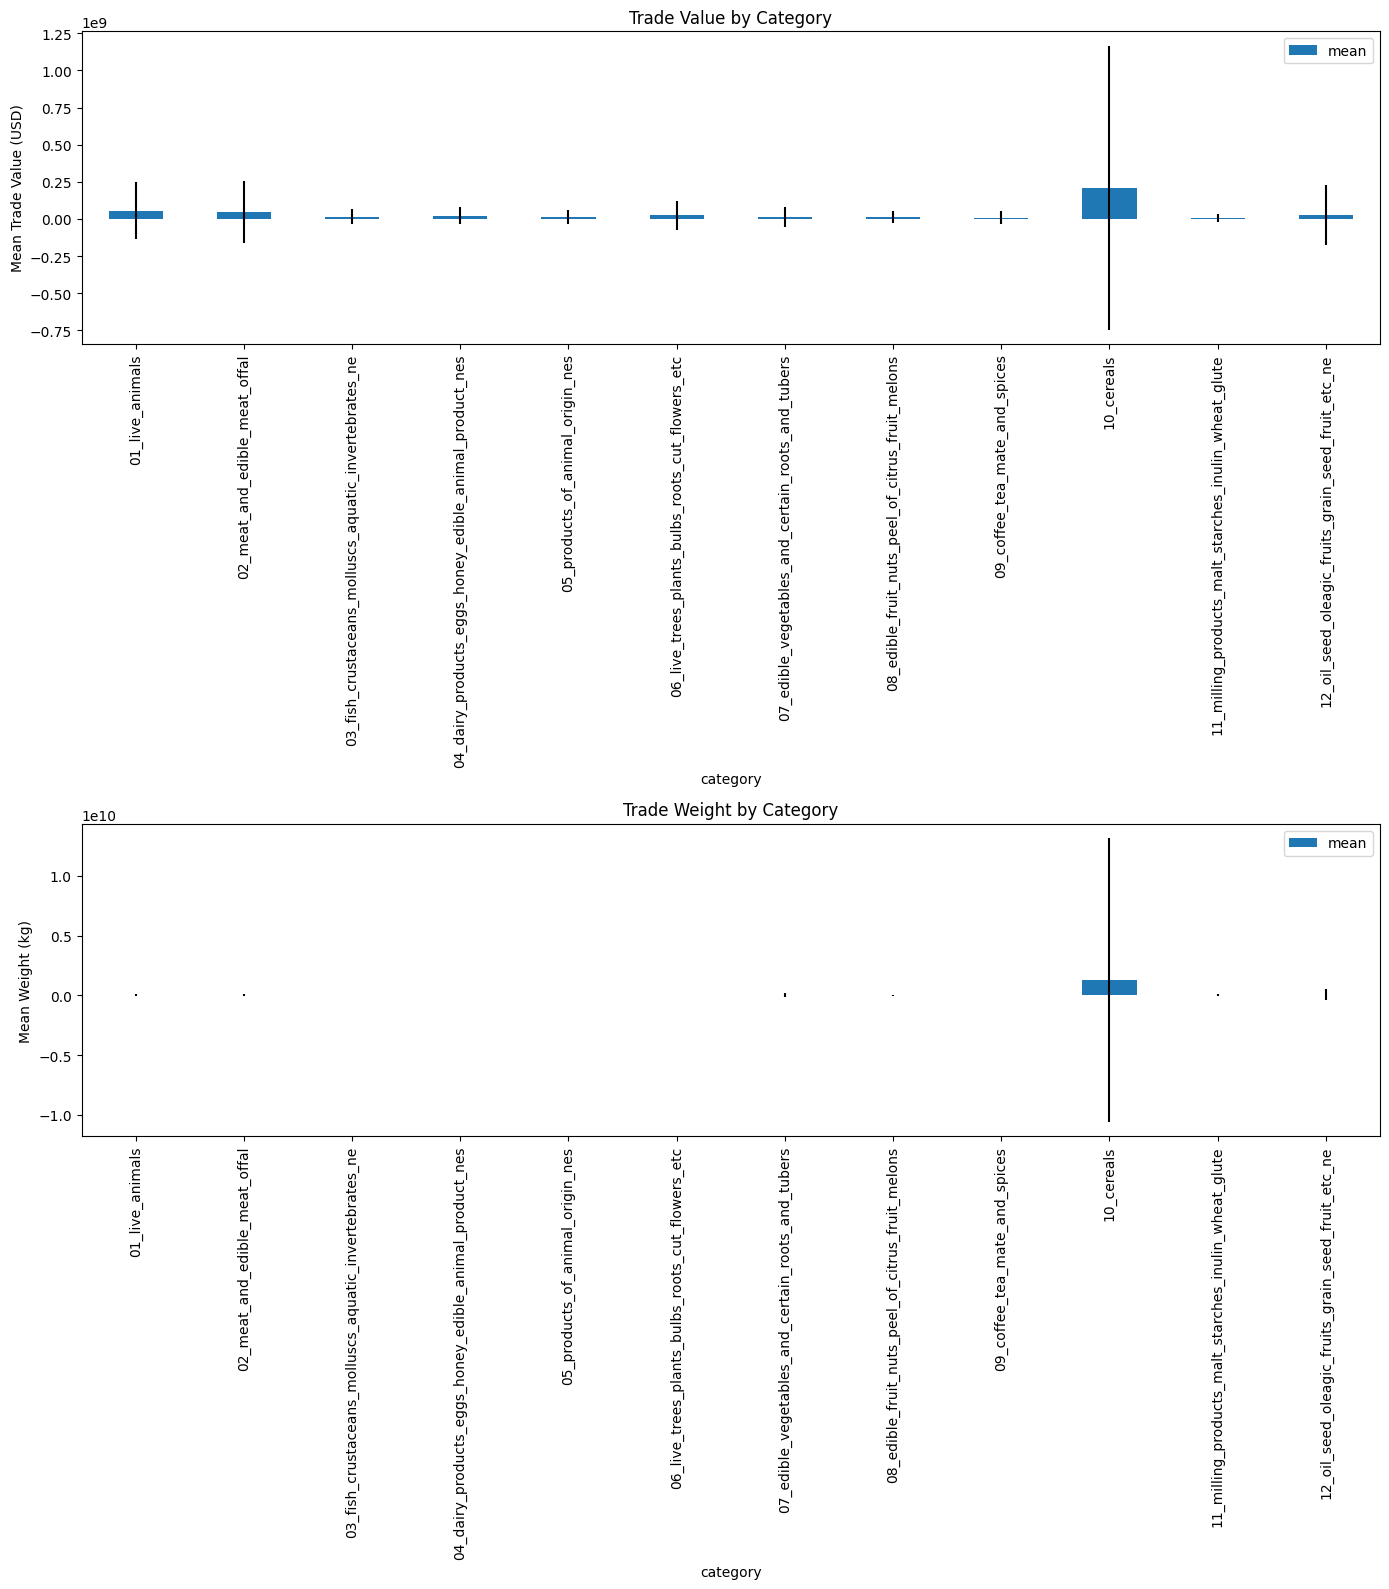

In [86]:
category_stats = df.groupby('category').agg({
    'trade_usd': ['mean', 'std'],
    'weight_kg': ['mean', 'std']
})

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 16)) 

# Plot for 'trade_usd'
category_stats['trade_usd'].plot(kind='bar', ax=ax1, yerr='std')
ax1.set_title('Trade Value by Category')
ax1.set_ylabel('Mean Trade Value (USD)')
ax1.tick_params(axis='x', rotation=90)

# Plot for 'weight_kg'
category_stats['weight_kg'].plot(kind='bar', ax=ax2, yerr='std')
ax2.set_title('Trade Weight by Category')
ax2.set_ylabel('Mean Weight (kg)')
ax2.tick_params(axis='x', rotation=90)

plt.tight_layout()
plt.show()

In [89]:
df[df['category']=='10_cereals'].describe()

c:\Users\kvsvy\AppData\Local\Programs\Python\Python312\Lib\site-packages\pandas\core\nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)


,year,trade_usd,weight_kg,quantity,unit_price,trade_value
count,3304,3.304000e+03,3.304000e+03,3.304000e+03,3304.000000,3.304000e+03
mean,2003-05-13 15:48:22.663438208,2.117284e+08,1.278937e+09,1.278937e+09,inf,1.772559e+08
min,1988-01-01 00:00:00,1.000000e+00,0.000000e+00,0.000000e+00,0.000147,-9.151077e+08
25%,1997-01-01 00:00:00,1.079175e+05,1.743725e+05,1.743725e+05,0.215089,-4.673775e+05
50%,2004-01-01 00:00:00,2.153987e+06,4.100000e+06,4.100000e+06,0.399999,2.135850e+04
75%,2010-01-01 00:00:00,3.507129e+07,8.810692e+07,8.810692e+07,0.900778,5.973378e+06
max,2016-01-01 00:00:00,1.373323e+10,6.140000e+11,6.140000e+11,inf,1.373323e+10
std,NaN,9.560419e+08,1.188744e+10,1.188744e+10,NaN,9.630314e+08


- Cereals category shows the highest mean trade value and weight.
- Some categories (ie. Meat, cereals etc) show high variability (large error bars), indicating volatile trade patterns.
- Certain categories (ie. 11. milling etc) consistently have low trade values, which could represent niche markets.

### 10. How does the distribution of trade values change over time?

Top 5 largest trade values:
            year country_or_area                             commodity  \
48871 2011-01-01             USA                Maize except seed corn   
49011 2008-01-01             USA                Maize except seed corn   
48996 2008-01-01             USA  Wheat except durum wheat, and meslin   
48856 2011-01-01             USA  Wheat except durum wheat, and meslin   
48732 2014-01-01             USA                Maize except seed corn   

         trade_usd  
48871  13733233126  
49011  13540980797  
48996  11045744836  
48856  10882666081  
48732  10711078973  


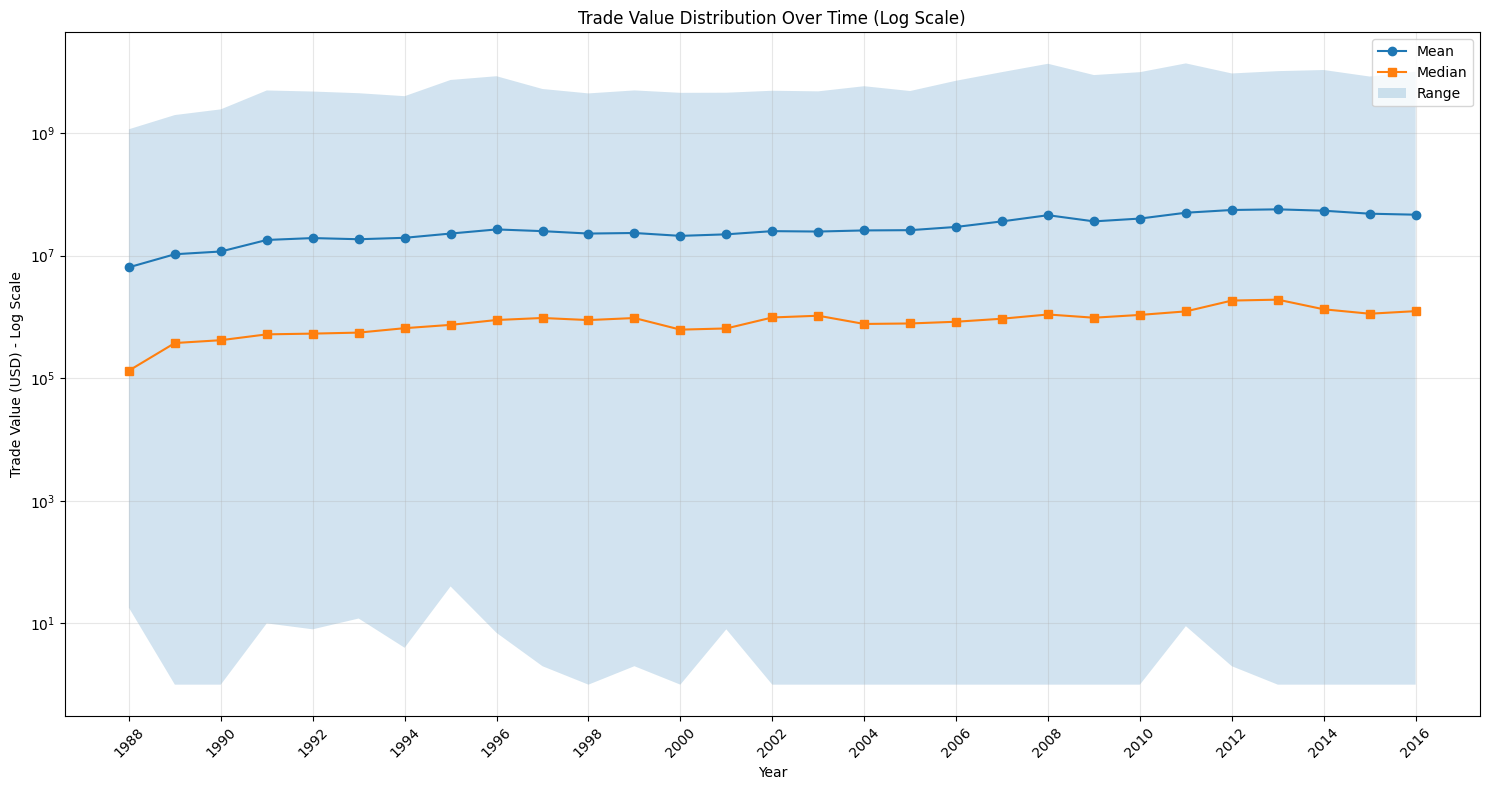

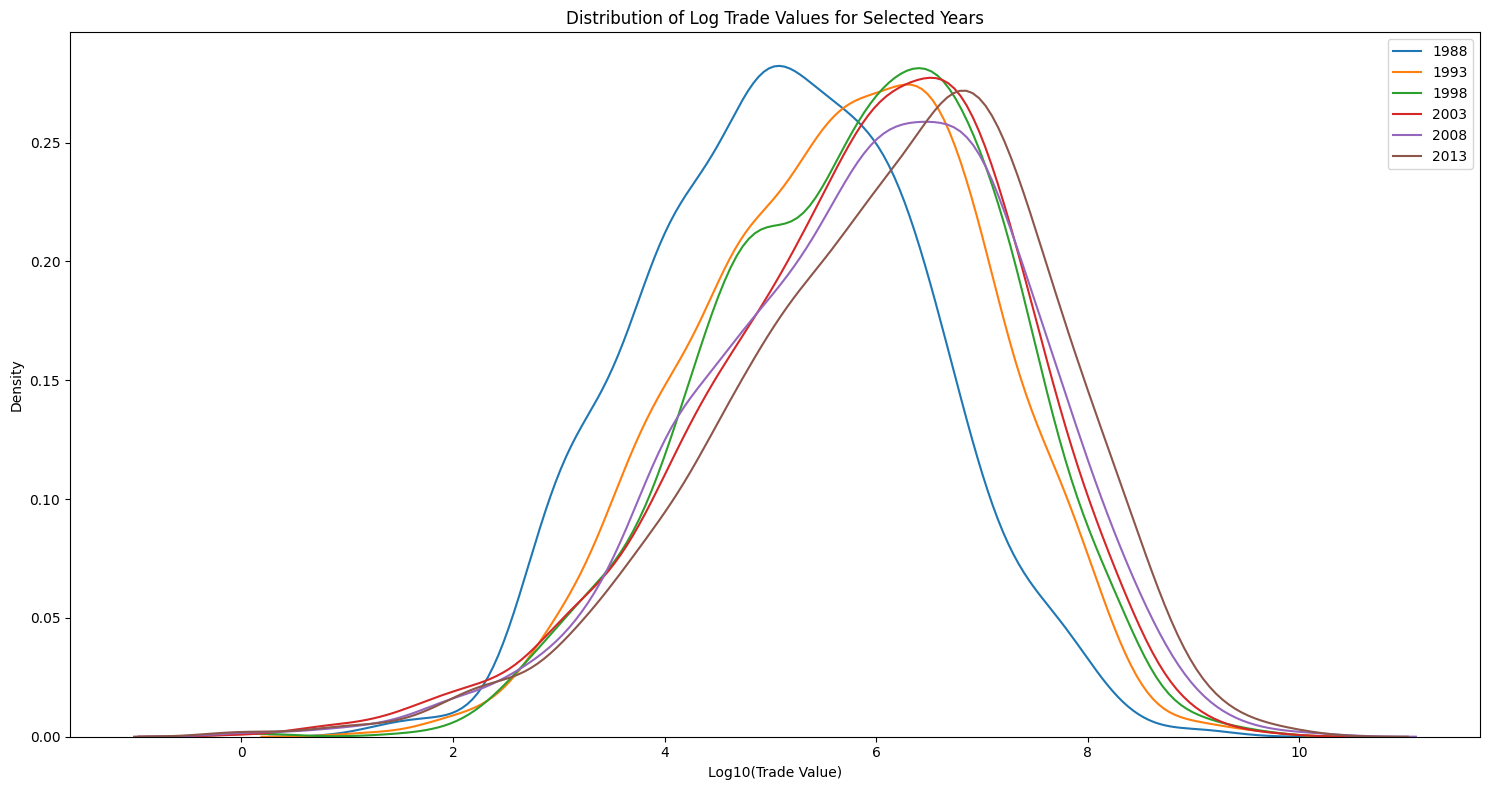

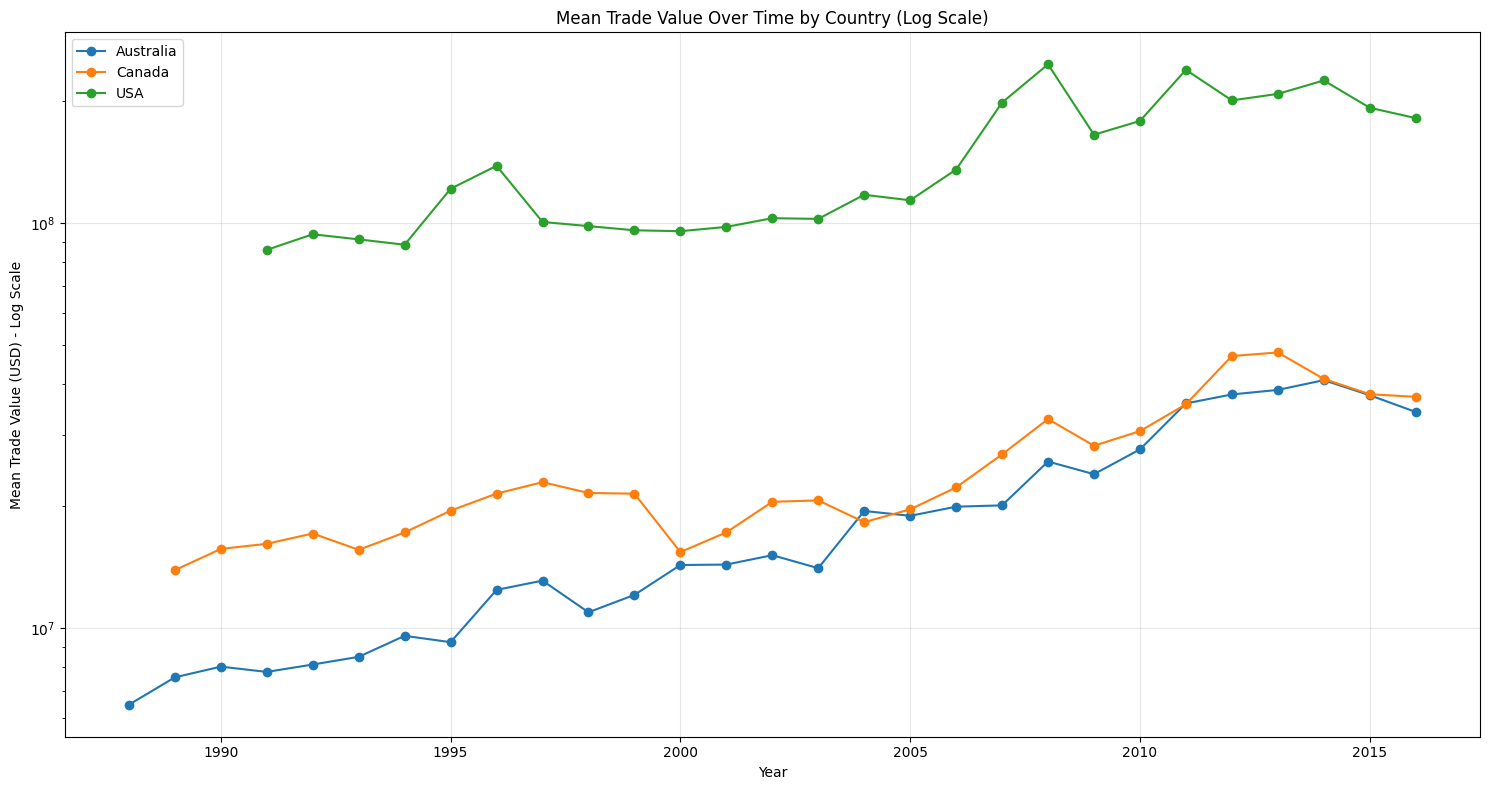

In [105]:
# 1. Check for extreme outliers
print("Top 5 largest trade values:")
print(df.nlargest(5, 'trade_usd')[['year', 'country_or_area', 'commodity', 'trade_usd']])

# 2. Plot with log scale
yearly_stats = df.groupby(df['year'].dt.year)['trade_usd'].agg(['mean', 'median', 'min', 'max'])

plt.figure(figsize=(15, 8))
plt.semilogy(yearly_stats.index, yearly_stats['mean'], label='Mean', marker='o')
plt.semilogy(yearly_stats.index, yearly_stats['median'], label='Median', marker='s')
plt.fill_between(yearly_stats.index, yearly_stats['min'], yearly_stats['max'], alpha=0.2, label='Range')

plt.title('Trade Value Distribution Over Time (Log Scale)')
plt.xlabel('Year')
plt.ylabel('Trade Value (USD) - Log Scale')
plt.legend()
plt.xticks(yearly_stats.index[::2], rotation=45)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# 3. Examine data distribution
plt.figure(figsize=(15, 8))
for year in yearly_stats.index[::5]:  # Plot every 5th year for clarity
    year_data = df[df['year'].dt.year == year]['trade_usd']
    sns.kdeplot(np.log10(year_data[year_data > 0]), label=str(year))

plt.title('Distribution of Log Trade Values for Selected Years')
plt.xlabel('Log10(Trade Value)')
plt.ylabel('Density')
plt.legend()
plt.tight_layout()
plt.show()

# 4. Investigate by country
plt.figure(figsize=(15, 8))
for country in df['country_or_area'].unique():
    country_data = df[df['country_or_area'] == country].groupby(df['year'].dt.year)['trade_usd'].mean()
    plt.semilogy(country_data.index, country_data, label=country, marker='o')

plt.title('Mean Trade Value Over Time by Country (Log Scale)')
plt.xlabel('Year')
plt.ylabel('Mean Trade Value (USD) - Log Scale')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()



- Trade values have generally increased over time for all three countries.
- The distribution of trade values has become more spread out over the years, indicating greater variability in trade amounts.
- There are significant differences in trade volumes between the three countries, with the USA dominating in terms of mean trade value.
- Economic events (like the 2008 financial crisis) seem to have impacted trade patterns, especially visible in the USA data.

### 11. Trade Anomalies Detection

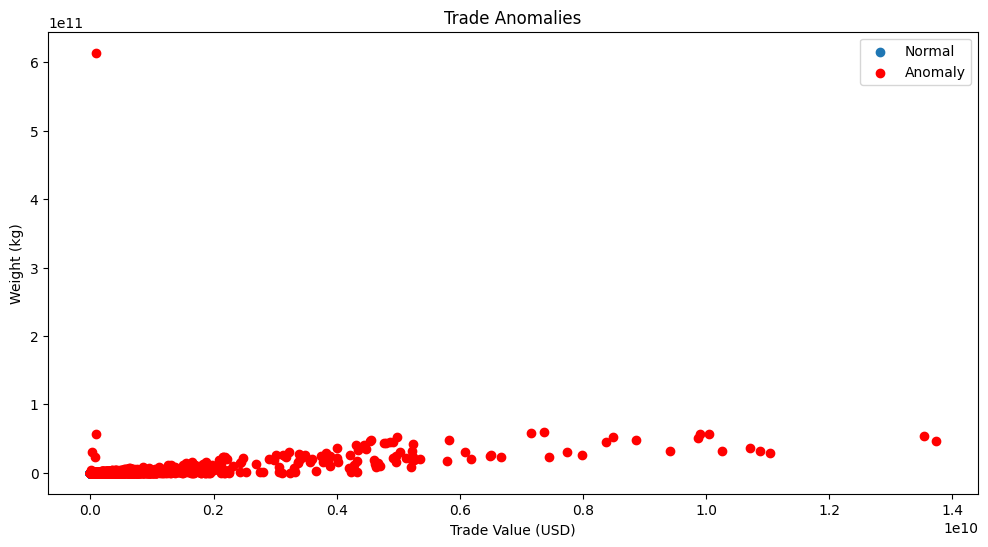

In [108]:
X = df[['trade_usd', 'weight_kg']].values
clf = IsolationForest(contamination=0.1, random_state=42)
df['anomaly'] = clf.fit_predict(X)

plt.figure(figsize=(12, 6))
plt.scatter(df[df['anomaly'] == 1]['trade_usd'], 
            df[df['anomaly'] == 1]['weight_kg'], 
            label='Normal')
plt.scatter(df[df['anomaly'] == -1]['trade_usd'], 
            df[df['anomaly'] == -1]['weight_kg'], 
            color='red', label='Anomaly')
plt.title('Trade Anomalies')
plt.xlabel('Trade Value (USD)')
plt.ylabel('Weight (kg)')
plt.legend()
plt.show()

Australia:
  Total trades: 24921
  Anomalies detected: 1246 (5.00%)
  Highest anomalous trade value: $6,672,933,181.00
  Highest anomalous weight: 26,444,459,226.00 kg

Canada:
  Total trades: 29932
  Anomalies detected: 1496 (5.00%)
  Highest anomalous trade value: $5,218,774,906.00
  Highest anomalous weight: 21,228,911,498.00 kg

USA:
  Total trades: 4237
  Anomalies detected: 212 (5.00%)
  Highest anomalous trade value: $13,733,233,126.00
  Highest anomalous weight: 614,000,000,000.00 kg



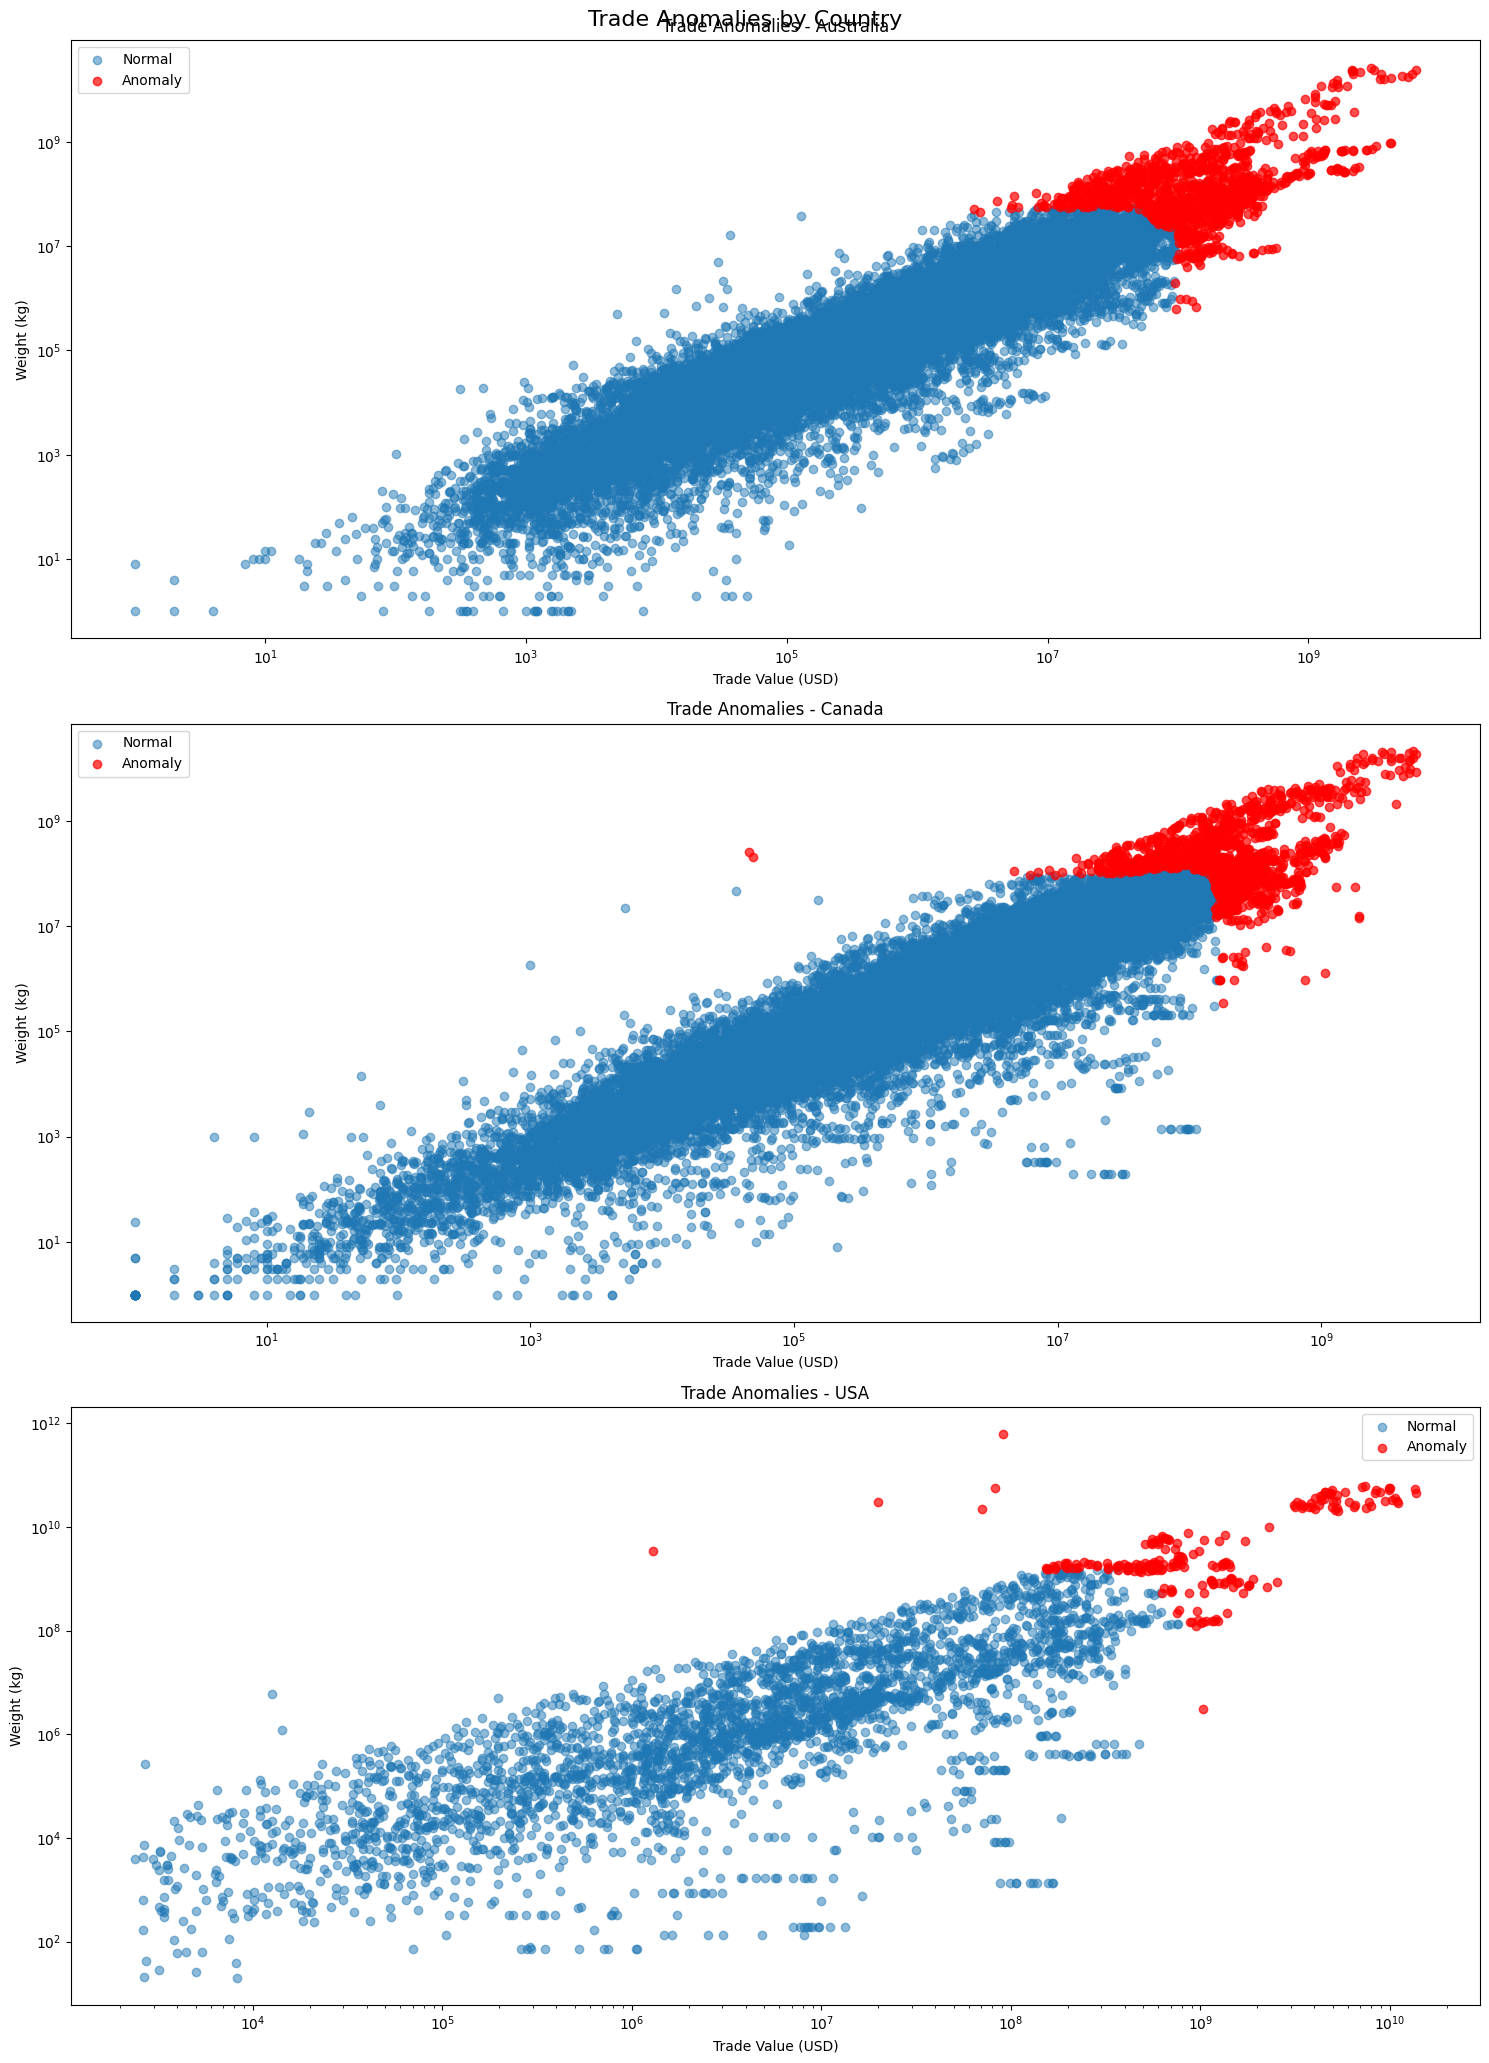

Common characteristics of anomalies across all countries:
          trade_usd     weight_kg      quantity
count  5.909000e+03  5.909000e+03  5.909000e+03
mean   2.714487e+08  8.442649e+08  8.471254e+08
std    7.614656e+08  8.912050e+09  8.912324e+09
min    3.636500e+04  0.000000e+00  0.000000e+00
25%    5.732650e+07  3.568530e+07  3.270654e+07
50%    9.882530e+07  7.294746e+07  7.042980e+07
75%    2.049444e+08  1.782927e+08  1.744436e+08
max    1.373323e+10  6.140000e+11  6.140000e+11

Top 10 commodities in anomalous trades:
commodity
Wheat except durum wheat, and meslin               129
Rice, semi-milled or wholly milled                 124
Barley                                             122
Maize except seed corn                             121
Shrimps and prawns, frozen                         101
Plants, live (including their roots),nes           100
Durum wheat                                        100
Bovine animals, live, except pure-bred breeding     97
Oats               

In [109]:
def detect_anomalies(data, contamination=0.05):
    clf = IsolationForest(contamination=contamination, random_state=42)
    return clf.fit_predict(data[['trade_usd', 'weight_kg']])

def plot_anomalies(data, country, ax):
    ax.scatter(data[data['anomaly'] == 1]['trade_usd'], 
               data[data['anomaly'] == 1]['weight_kg'], 
               label='Normal', alpha=0.5)
    ax.scatter(data[data['anomaly'] == -1]['trade_usd'], 
               data[data['anomaly'] == -1]['weight_kg'], 
               color='red', label='Anomaly', alpha=0.7)
    ax.set_title(f'Trade Anomalies - {country}')
    ax.set_xlabel('Trade Value (USD)')
    ax.set_ylabel('Weight (kg)')
    ax.legend()
    ax.set_xscale('log')
    ax.set_yscale('log')

# Analyze anomalies for each country
countries = df['country_or_area'].unique()
fig, axes = plt.subplots(len(countries), 1, figsize=(15, 7*len(countries)))
fig.suptitle('Trade Anomalies by Country', fontsize=16)

for i, country in enumerate(countries):
    country_data = df[df['country_or_area'] == country].copy()
    country_data['anomaly'] = detect_anomalies(country_data)
    plot_anomalies(country_data, country, axes[i] if len(countries) > 1 else axes)
    
    # Print summary statistics
    total_trades = len(country_data)
    anomalies = (country_data['anomaly'] == -1).sum()
    print(f"{country}:")
    print(f"  Total trades: {total_trades}")
    print(f"  Anomalies detected: {anomalies} ({anomalies/total_trades:.2%})")
    print(f"  Highest anomalous trade value: ${country_data[country_data['anomaly'] == -1]['trade_usd'].max():,.2f}")
    print(f"  Highest anomalous weight: {country_data[country_data['anomaly'] == -1]['weight_kg'].max():,.2f} kg")
    print()

plt.tight_layout()
plt.show()

# Optional: Analyze common characteristics of anomalies across countries
all_anomalies = df[df['anomaly'] == -1]
print("Common characteristics of anomalies across all countries:")
print(all_anomalies[['trade_usd', 'weight_kg', 'quantity']].describe())

# Optional: Top commodities in anomalies
top_anomaly_commodities = all_anomalies['commodity'].value_counts().head(10)
print("\nTop 10 commodities in anomalous trades:")
print(top_anomaly_commodities)

- All three countries show a strong correlation between trade value and weight for normal trades, which is expected.
- The USA has a notably larger scale of trade in terms of both value and weight compared to Australia and Canada.
- Anomalies tend to occur more frequently at the extremes of trade value and weight for all countries.

### 12. Commodity Concentration Index (HHI)

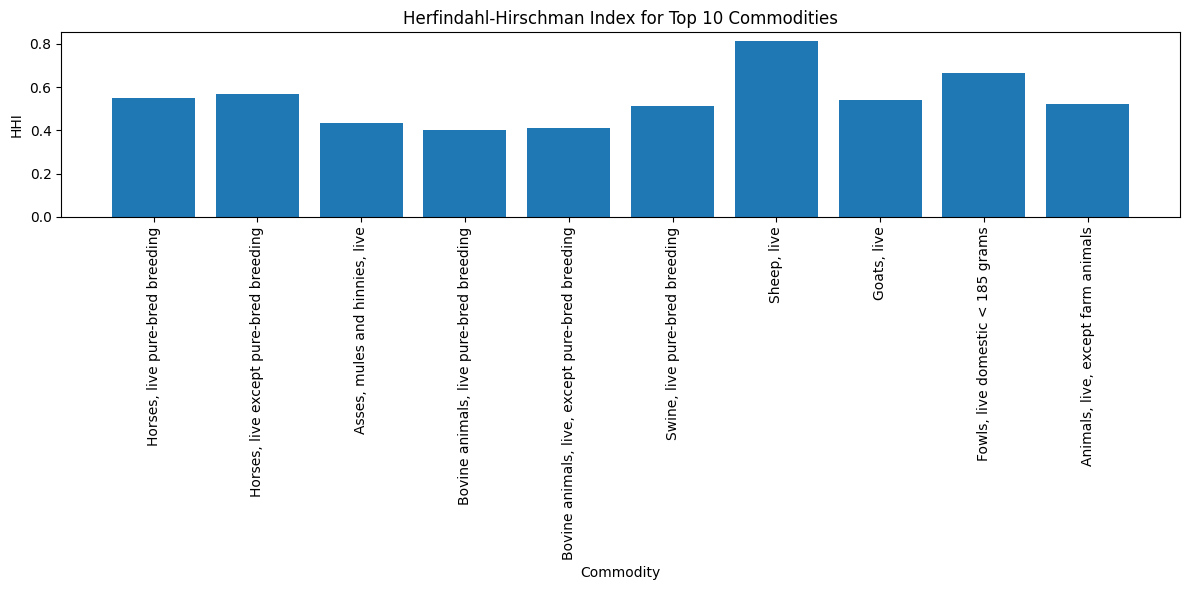

In [98]:
def calculate_hhi(df, commodity):
    commodity_data = df[df['commodity'] == commodity]
    market_shares = commodity_data.groupby('country_or_area')['trade_usd'].sum() / commodity_data['trade_usd'].sum()
    hhi = (market_shares ** 2).sum()
    return hhi

# Calculate HHI for the top 10 commodities
top_commodities = df['commodity'].unique()[:10]
hhi_values = [calculate_hhi(df, commodity) for commodity in top_commodities]

# Plotting the HHI values
plt.figure(figsize=(12, 6))
plt.bar(top_commodities, hhi_values)
plt.title('Herfindahl-Hirschman Index for Top 10 Commodities')
plt.xlabel('Commodity')
plt.ylabel('HHI')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

- Some commodities (ie. sheep live) show high concentration, indicating market dominance by certain countries.
- Lower HHI values suggest more competitive markets for those commodities.
- Highly concentrated markets might be more vulnerable to supply shocks.

### 13. Commodity Volatility

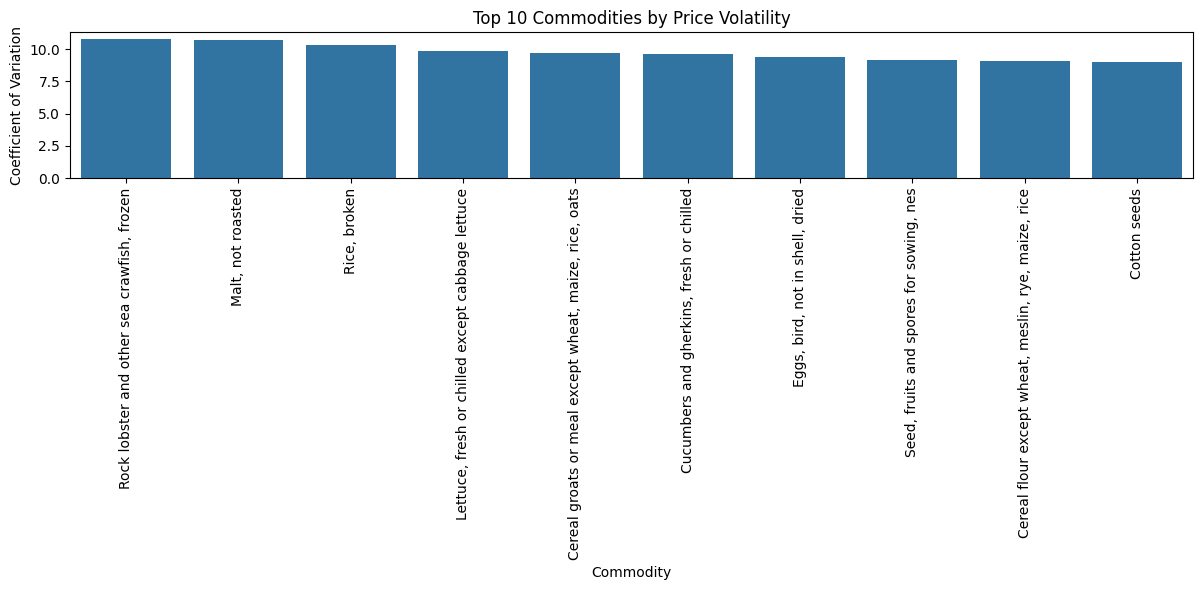

In [100]:
commodity_volatility = df.groupby('commodity')['unit_price'].agg(['mean', 'std'])
commodity_volatility['coefficient_of_variation'] = commodity_volatility['std'] / commodity_volatility['mean']
commodity_volatility = commodity_volatility.sort_values('coefficient_of_variation', ascending=False)

plt.figure(figsize=(12, 6))
sns.barplot(x=commodity_volatility.index[:10], y='coefficient_of_variation', data=commodity_volatility[:10])
plt.title('Top 10 Commodities by Price Volatility')
plt.xlabel('Commodity')
plt.ylabel('Coefficient of Variation')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

- Certain commodities (ie. rock lobster etc) consistently show high price volatility.
- Volatile prices could be due to factors like weather dependence, or changing demand.
- Less volatile commodities might represent more stable, predictable markets.

### 14. Trade Partner Analysis

<Figure size 1200x600 with 0 Axes>

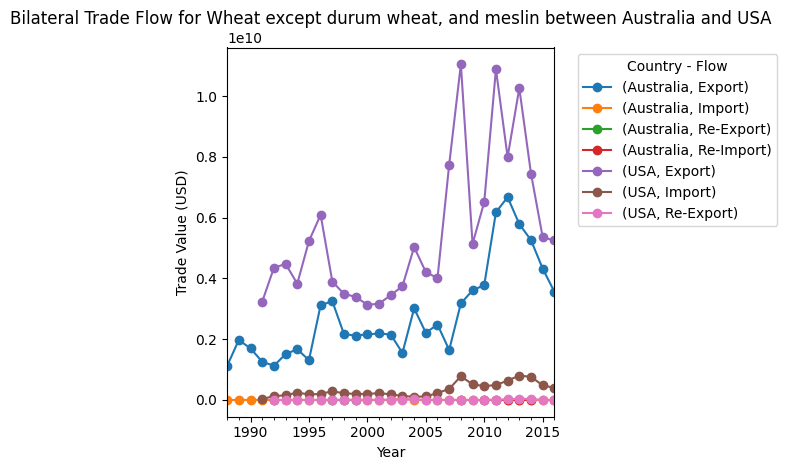

In [101]:
country1, country2 = 'Australia', 'USA'
bilateral_trade = df[(df['country_or_area'].isin([country1, country2])) & 
                     (df['commodity'] == commodity)]
pivot_trade = bilateral_trade.pivot_table(values='trade_usd', index='year', 
                                          columns=['country_or_area', 'flow'], 
                                          aggfunc='sum')

plt.figure(figsize=(12, 6))
pivot_trade.plot(marker='o')
plt.title(f'Bilateral Trade Flow for {commodity} between {country1} and {country2}')
plt.xlabel('Year')
plt.ylabel('Trade Value (USD)')
plt.legend(title='Country - Flow', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

- Trade flows between Australia and the USA show clear trends over time.
- Trade imbalances between the two countries are evident for wheat

## Insights 

- Agricultural products, especially grains, play a crucial role in the trade relationships between Australia, Canada, and the USA.
- The USA consistently dominates in terms of trade volume and market share, reflecting its larger economy and agricultural output.
- Trade patterns show clear seasonality and long-term growth trends, but with increasing variability over time.
- Price volatility and market concentration vary significantly across commodities, indicating different levels of market stability and competition.
- Anomalies in trade data often occur in high-value transactions, suggesting the need for careful monitoring of large trades.
- While overall trade has grown, the widening gap between mean and median trade values suggests increasing inequality in trade distribution.